In [1]:
# !pip install tensorflow-gpu # make sure cuda toolkit and nvidia dependencies/drivers are correctly installed
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install mlflow
# !pip install scipy
# !pip install keras

In [98]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px

from pycm import ConfusionMatrix

from keras.models import Model
from keras.layers import Input, LSTM, Bidirectional, Dense, Masking, Reshape, Activation, Masking
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, concatenate
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical, timeseries_dataset_from_array

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from time import time
from datetime import datetime, timedelta

from pathlib import Path

from data_utils import get_vol, get_touches, get_labels, get_horizons, load_data, label_series, verify_labels
from ModelArchitecture import generate_mlstmfcn


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
2022-03-03 10:48:17.661567: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 10:48:18.070025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 3384 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
dataset_df, names = load_data("../Data/")

In [24]:
BTC_SAMPLE = pd.DataFrame(index = dataset_df.index)
BTC_SAMPLE["Close"] = dataset_df['BTC_USD-5m']
BTC_SAMPLE.Close = BTC_SAMPLE.Close.pct_change(1).mul(100)
BTC_SAMPLE = BTC_SAMPLE.fillna(0.0)
print(BTC_SAMPLE.head(5))



                        Close
Timestamp                    
2020-01-16 00:00:00  0.000000
2020-01-16 00:05:00 -0.014244
2020-01-16 00:10:00 -0.230993
2020-01-16 00:15:00 -0.133613
2020-01-16 00:20:00 -0.660447


In [6]:
labels = label_series(BTC_SAMPLE.Close)

In [8]:
labels.to_csv('./Processed/BTClabels.csv')

In [9]:
# labels = pd.read_csv('./Processed/BTClabels.csv')
# labels.set_index('Timestamp', inplace=True)

In [25]:
print("Price Index 0: {a} vs. Label Index 0: {b}".format(a=BTC_SAMPLE.index[0], b=labels.index[0]))
print("Price Index -1: {a} vs. Price Index -1: {b}".format(a=BTC_SAMPLE.index[-1], b=labels.index[-1]))

Price Index 0: 2020-01-16 00:00:00 vs. Label Index 0: 2020-01-16 01:10:00
Price Index -1: 2022-01-15 10:50:00 vs. Price Index -1: 2022-01-15 10:35:00


In [26]:
BTC_SAMPLE = BTC_SAMPLE.truncate(before=pd.Timestamp(labels.index[0]), \
    after=pd.Timestamp(labels.index[-1]))
labels = labels.truncate(before=pd.Timestamp(BTC_SAMPLE.index[0]), \
     after=pd.Timestamp(BTC_SAMPLE.index[-1]))

np_labels = labels.to_numpy()
one_hot_encoded_labels = to_categorical(np_labels, num_classes=3)
 
print(labels.value_counts(normalize=True, dropna=True))
print(one_hot_encoded_labels.shape)


 0.0    0.566407
 1.0    0.217828
-1.0    0.215765
Name: label, dtype: float64
(209955, 3)


In [27]:
values = BTC_SAMPLE.Close.to_numpy()
if values.ndim == 1:
    values = values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
X = scaled


input_timesteps = 128
batch_size = 128

# split into train and test sets (Train: 68%, Val: 12%, Test: 20%)
trainX, testX, trainY, testY = train_test_split(X, one_hot_encoded_labels, test_size=0.10, random_state=42, shuffle = False)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.15, random_state=42, shuffle=False)

train_dataset = timeseries_dataset_from_array(trainX, trainY, input_timesteps, batch_size=batch_size, shuffle=False)
test_dataset = timeseries_dataset_from_array(testX, testY, input_timesteps, batch_size=batch_size, shuffle=False)
val_dataset = timeseries_dataset_from_array(valX, valY, input_timesteps, batch_size=batch_size, shuffle=False)

print("trainX Shape:" + str(trainX.shape))
print("trainY Shape:" + str(trainY.shape))
print("testX Shape:" + str(testX.shape))
print("testY Shape:" + str(testY.shape))

verify_labels(train_dataset, trainY, batch_size)

trainX Shape:(160615, 1)
trainY Shape:(160615, 3)
testX Shape:(20996, 1)
testY Shape:(20996, 3)
Unequal Shapes at Index 1253 (If the index is large then it is the remainder of the set after batch processing)
Target Shape: (104, 3) vs. Label Sequence Slice Shape: (128, 3)


In [28]:
units = 128 # Arbituary Number
features = trainX.shape[1] # Number of different trading pairs in the dataframe ie. BTC/USD (aka: # of columns)
num_epoch = 25
learning_rate = 0.00144
class_weight = { 0 : 1, 1 : 1, 2: 1}
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

# input_shape=(train_sample_X[1].shape, train_sample_X[2].shape)
model = generate_mlstmfcn(input_timesteps, features, 3, 24)



adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Stop training when a monitored quantity has stopped improving.
callbacks = [EarlyStopping(monitor="loss", \
                            min_delta = 0.00001, \
                            patience = 50, mode = 'auto', \
                            restore_best_weights=True), \
                            tensorboard_callback] 


# Using regression loss function 'Mean Standard Error' and validation metric 'Mean Absolute Error'
model.compile(loss='categorical_crossentropy', optimizer=adam, weighted_metrics=['accuracy'])


# fit network
history = model.fit(train_dataset, \
                            epochs=num_epoch, \
                            validation_data=val_dataset, \
                            callbacks = callbacks, \
                            verbose=2, \
                            shuffle=False, \
                            initial_epoch=0, \
                            class_weight=class_weight
                            )


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 128)     1152        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128)    512         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 128, 128)     0           ['batch_normalization_3[0][

In [29]:
# Return loss value and metric value
score = model.evaluate_generator(test_dataset, verbose=0)   
print("Loss: {cce}, Accuracy: {acc}".format(cce=score[0], acc=score[1]))

Loss: 0.7532576322555542, Accuracy: 0.7322344183921814


In [111]:
predictions_array = model.predict(test_dataset, callbacks=tensorboard_callback)
predictions_array = tf.one_hot(tf.argmax(predictions_array, axis=1), predictions_array.shape[1])
predictions_array = np.array(predictions_array)

verify_labels(test_dataset, testY, batch_size)

y_true_df = pd.DataFrame()

for batch in test_dataset:
    inputs, targets = batch
    temp = pd.DataFrame(targets[:].numpy())
    y_true_df = pd.concat([y_true_df, temp])

y_true = y_true_df.values
y_true = np.array(y_true)

print(y_true.shape, predictions_array.shape)


Unequal Shapes at Index 163 (If the index is large then it is the remainder of the set after batch processing)
Target Shape: (5, 3) vs. Label Sequence Slice Shape: (128, 3)
(20869, 3) (20869, 3)


In [112]:
pred_df = pd.DataFrame(predictions_array)
y_true_df = pd.DataFrame(y_true)
pred_df_counts = pred_df.value_counts(dropna=True)
y_true_df_counts = y_true_df.value_counts(dropna=True)
print(y_true_df_counts)
print(pred_df_counts)
total_cor_pred = (y_true * predictions_array).sum() 
print(f"Total Number of Correct Predictions 15 Minutes into the Future: {cor_pred}")
print(f"Total Number of Incorrect Predictions 15 Minutes into the Future: {y_true.shape[0] - cor_pred}")

0    1    2  
1.0  0.0  0.0    12024
0.0  0.0  1.0     4559
     1.0  0.0     4286
dtype: int64
0    1    2  
1.0  0.0  0.0    10164
0.0  0.0  1.0     5679
     1.0  0.0     5026
dtype: int64
Total Number of Correct Predictions 15 Minutes into the Future: 15281.0
Total Number of Incorrect Predictions 15 Minutes into the Future: 5588.0


[0, 0, 1] is sell
[0, 1, 0] is buy
[1, 0, 0] is expire

In [126]:
y_true = pd.get_dummies(y_true_df).idxmax(1)
y_pred = pd.get_dummies(pred_df).idxmax(1)

cm = ConfusionMatrix(actual_vector=y_true.values, predict_vector=y_pred.values)

In [128]:
print(cm)

Predict    0          1          2          
Actual
0          8329       1805       1890       

1          1057       3196       33         

2          778        25         3756       





Overall Statistics : 

95% CI                                                            (0.72623,0.73824)
ACC Macro                                                         0.82149
ARI                                                               0.3294
AUNP                                                              0.78214
AUNU                                                              0.80442
Bangdiwala B                                                      0.5523
Bennett S                                                         0.59835
CBA                                                               0.66333
CSI                                                               0.45966
Chi-Squared                                                       15270.06277
Chi-Squared DF                 

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

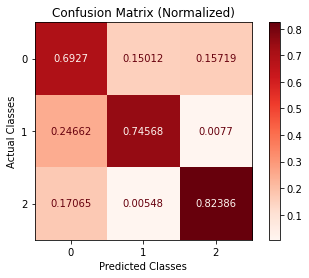

In [135]:
cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True,plot_lib="matplotlib")

In [17]:
%tensorboard --logdir ./logs/